In [1]:
import pandas
import konlpy
import gensim
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

import tensorflow as tf

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace = True)
    train_data= train_data.dropna(how='any')
    test_data.drop_duplicates(subset='document', inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제외
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [9]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5146 - accuracy: 0.7343 - val_loss: 0.3615 - val_accuracy: 0.8457
Epoch 2/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3416 - accuracy: 0.8560 - val_loss: 0.3446 - val_accuracy: 0.8475
Epoch 3/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3208 - accuracy: 0.8653 - val_loss: 0.3427 - val_accuracy: 0.8496
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3115 - accuracy: 0.8694 - val_loss: 0.3458 - val_accuracy: 0.8512
Epoch 5/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3034 - accuracy: 0.8728 - val_loss: 0.3423 - val_accuracy: 0.8498
Epoch 6/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2971 - accuracy: 0.8754 - val_loss: 0.3429 - val_accuracy: 0.8507
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2933 - accuracy: 0.8777 - val_loss: 0.3451 - val_accuracy: 0.8512
Epoch 

In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4502 - accuracy: 0.8464
[0.45018717646598816, 0.8464308381080627]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
import matplotlib.pyplot as plt

def plot_history(histordy_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

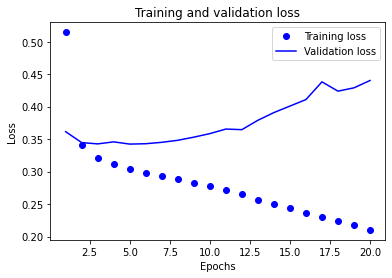

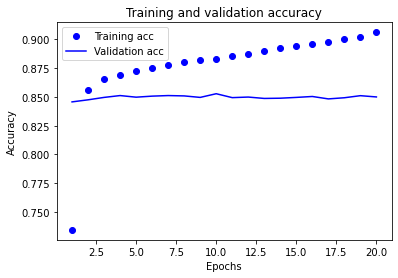

In [15]:
plot_history(history_dict)

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [17]:
import os
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'

In [18]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [20]:
from tensorflow.keras.initializers import Constant
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 9ms/step - loss: 0.6927 - accuracy: 0.5048 - val_loss: 0.6913 - val_accuracy: 0.5102
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.4974 - accuracy: 0.7643 - val_loss: 0.3698 - val_accuracy: 0.8410
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3469 - accuracy: 0.8559 - val_loss: 0.3499 - val_accuracy: 0.8475
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3189 - accuracy: 0.8702 - val_loss: 0.3431 - val_accuracy: 0.8520
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3018 - accuracy: 0.8787 - val_loss: 0.3457 - val_accuracy: 0.8520
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2864 - accuracy: 0.8850 - val_loss: 0.3404 - val_accuracy: 0.8542
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2733 - accuracy: 0.8903 - val_loss: 0.3456 - val_accuracy: 0.8526
Epoch 

In [22]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3764 - accuracy: 0.8439
[0.3763886094093323, 0.8439489603042603]


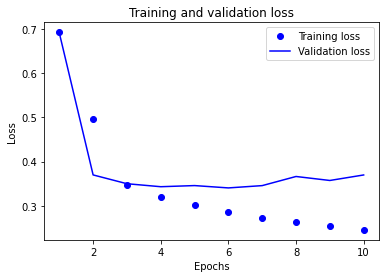

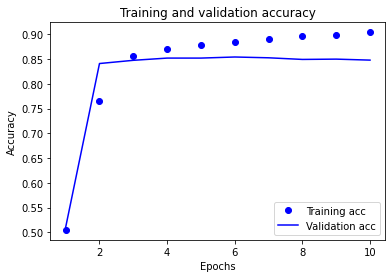

In [23]:
history_dict = history.history
plot_history(history_dict)

In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.7))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.7))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            33616     
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 16)            64        
_________________________________________________________________
dropout (Dropout)            (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 16)            

In [25]:
# 학습의 진행
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop]
                   )

Epoch 1/50
266/266 [==============================] - 5s 11ms/step - loss: 1.3011 - accuracy: 0.5070 - val_loss: 0.9189 - val_accuracy: 0.5016
Epoch 2/50
266/266 [==============================] - 2s 9ms/step - loss: 0.7907 - accuracy: 0.5364 - val_loss: 0.7131 - val_accuracy: 0.5614
Epoch 3/50
266/266 [==============================] - 2s 9ms/step - loss: 0.6073 - accuracy: 0.7033 - val_loss: 0.5933 - val_accuracy: 0.6839
Epoch 4/50
266/266 [==============================] - 2s 9ms/step - loss: 0.4689 - accuracy: 0.8015 - val_loss: 0.5672 - val_accuracy: 0.7078
Epoch 5/50
266/266 [==============================] - 2s 9ms/step - loss: 0.4227 - accuracy: 0.8257 - val_loss: 0.8286 - val_accuracy: 0.5860
Epoch 6/50
266/266 [==============================] - 2s 9ms/step - loss: 0.3991 - accuracy: 0.8383 - val_loss: 0.5509 - val_accuracy: 0.7015
Epoch 7/50
266/266 [==============================] - 2s 9ms/step - loss: 0.3834 - accuracy: 0.8457 - val_loss: 0.4111 - val_accuracy: 0.8195
Epoch

In [26]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3818 - accuracy: 0.8402
[0.3817538022994995, 0.8401855230331421]


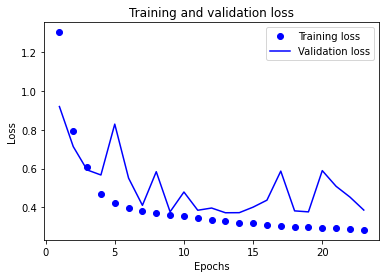

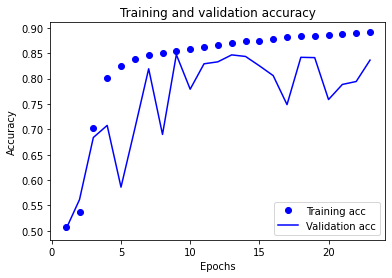

In [27]:
history_dict = history.history
plot_history(history_dict)

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,002,449
Trainable params: 3,002,433
Non-trainable params: 16
___________________________________________

In [29]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 7ms/step - loss: 0.5446 - accuracy: 0.7320 - val_loss: 0.4321 - val_accuracy: 0.8268
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3995 - accuracy: 0.8265 - val_loss: 0.6271 - val_accuracy: 0.7079
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3485 - accuracy: 0.8530 - val_loss: 0.3505 - val_accuracy: 0.8468
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3129 - accuracy: 0.8719 - val_loss: 0.6769 - val_accuracy: 0.7276
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2814 - accuracy: 0.8885 - val_loss: 0.4103 - val_accuracy: 0.8271
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2469 - accuracy: 0.9033 - val_loss: 0.7727 - val_accuracy: 0.7391
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2116 - accuracy: 0.9193 - val_loss: 0.5678 - val_accuracy: 0.8090
Epoch 

In [30]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7348 - accuracy: 0.8195
[0.7347856163978577, 0.8195170760154724]


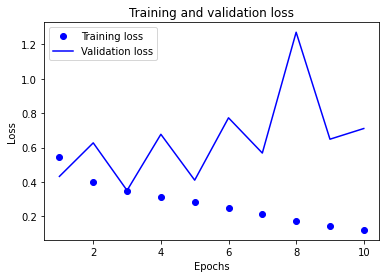

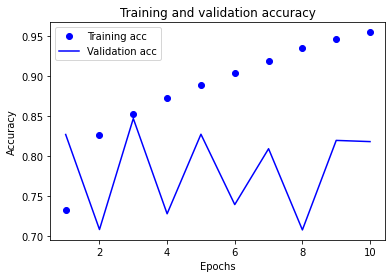

In [31]:
history_dict = history.history
plot_history(history_dict)

In [123]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.5)) 
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()


model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 41, 256)           439296    
_________________________________________________________________
dropout_38 (Dropout)         (None, 41, 256)           0         
_________________________________________________________________
dense_52 (Dense)             (None, 41, 128)           32896     
_________________________________________________________________
dropout_39 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
dense_53 (Dense)             (None, 41, 1)             129       
Total params: 3,472,321
Trainable params: 3,472,321
Non-trainable params: 0
___________________________________________

In [124]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 13s 36ms/step - loss: 0.6879 - accuracy: 0.5240 - val_loss: 0.5419 - val_accuracy: 0.7399
Epoch 2/5
266/266 [==============================] - 9s 34ms/step - loss: 0.4143 - accuracy: 0.8170 - val_loss: 0.3440 - val_accuracy: 0.8478
Epoch 3/5
266/266 [==============================] - 9s 34ms/step - loss: 0.3293 - accuracy: 0.8615 - val_loss: 0.3308 - val_accuracy: 0.8538
Epoch 4/5
266/266 [==============================] - 9s 34ms/step - loss: 0.3004 - accuracy: 0.8749 - val_loss: 0.3195 - val_accuracy: 0.8608
Epoch 5/5
266/266 [==============================] - 9s 33ms/step - loss: 0.2780 - accuracy: 0.8859 - val_loss: 0.3185 - val_accuracy: 0.8596


In [125]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3311 - accuracy: 0.8551
[0.3311207890510559, 0.855064332485199]


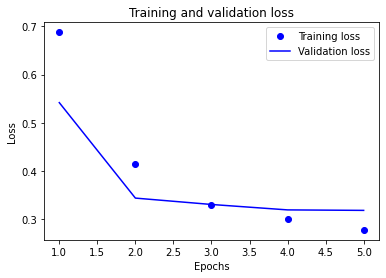

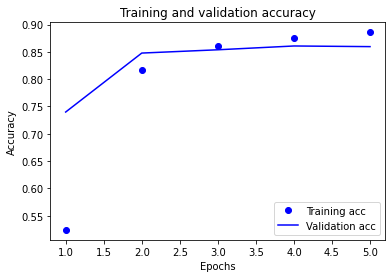

In [126]:
history_dict = history.history
plot_history(history_dict)

# Appendix
쓰인 기본 모델들

In [36]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(5))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

In [37]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

In [38]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# model.summary()